# Introduction

The goal of this notebook is to understand if movement between apo and holo states in the TCR corresponds to movement (or lack of movement) in the contacting pMHC and vice versa.

In [18]:
import glob
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from python_pdb.parsers import parse_pdb_to_pandas
from python_pdb.comparisons import rmsd
from python_pdb.formats.residue import THREE_TO_ONE_CODE
from tcr_structure_tools.cdr_numbering import assign_cdr_number

In [2]:
DATA_DIR = '/project/koohylab/bmcmaste/projects/tcr-pmhc-interface-analysis/data/apo-holo_TCR_pMHC_TCR-pMHC_structures_renumbered_aligned'

In [3]:
df = pd.DataFrame(glob.glob('**/*.pdb', root_dir=DATA_DIR, recursive=True), columns=['path'])
df

,path
0,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...
1,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...
2,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...
3,hla_a_02_01_slyntvatl_DRGSQS-IYSNGD-AVRTNSGYAL...
4,hla_a_02_01_slyntvatl_DRGSQS-IYSNGD-AVRTNSGYAL...
...,...
165,hla_b_07_02_aprgphggaasgl_NIATNDY-GYKTK-LVGEIL...
166,hla_b_07_02_aprgphggaasgl_NIATNDY-GYKTK-LVGEIL...
167,hla_a_02_01_yqfgpdfpia_NSAFQY-TYSSGN-AMRGDSSYK...
168,hla_a_02_01_yqfgpdfpia_NSAFQY-TYSSGN-AMRGDSSYK...


In [4]:
def get_chains(name):
    if name.startswith('pmhc_'):
        return {'alpha_chain': None, 'beta_chain': None, 'antigen_chain': 'C', 'mhc_chain': 'A'}
    
    if name.startswith('tcr_'):
        chains = name.split('.')[0].split('_')[2]
        return {'alpha_chain': chains[0], 'beta_chain': chains[1], 'antigen_chain': None, 'mhc_chain': None}
    
    if name.startswith('tcr-pmhc_'):
        chains = name.split('.')[0].split('_')[2]
        return {'alpha_chain': chains[0], 'beta_chain': chains[1], 'antigen_chain': chains[2], 'mhc_chain': chains[3]}

df[['group_name', 'aligned_to', 'name']] = df['path'].map(lambda path: path.split('/')).apply(pd.Series)
df[['molecule_type', 'pdb_id']] = df['name'].map(lambda name: name.split('.')[0].split('_')[0:2]).apply(pd.Series)
df[['alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain']] = df['name'].map(get_chains).apply(pd.Series)

df

,path,group_name,aligned_to,name,molecule_type,pdb_id,alpha_chain,beta_chain,antigen_chain,mhc_chain
0,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...,tcr-pmhc_5hhm_IJHF,pmhc_5hhn.pdb,pmhc,5hhn,None,None,C,A
1,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...,tcr-pmhc_5hhm_IJHF,tcr-pmhc_5hhm_IJHF.pdb,tcr-pmhc,5hhm,I,J,H,F
2,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...,tcr-pmhc_5hhm_IJHF,tcr_2vlm_DE.pdb,tcr,2vlm,D,E,None,None
3,hla_a_02_01_slyntvatl_DRGSQS-IYSNGD-AVRTNSGYAL...,hla_a_02_01_slyntvatl_DRGSQS-IYSNGD-AVRTNSGYAL...,tcr-pmhc_5nme_IJHF,tcr-pmhc_5nme_IJHF.pdb,tcr-pmhc,5nme,I,J,H,F
4,hla_a_02_01_slyntvatl_DRGSQS-IYSNGD-AVRTNSGYAL...,hla_a_02_01_slyntvatl_DRGSQS-IYSNGD-AVRTNSGYAL...,tcr-pmhc_5nme_IJHF,pmhc_1t22.pdb,pmhc,1t22,None,None,C,A
...,...,...,...,...,...,...,...,...,...,...
165,hla_b_07_02_aprgphggaasgl_NIATNDY-GYKTK-LVGEIL...,hla_b_07_02_aprgphggaasgl_NIATNDY-GYKTK-LVGEIL...,tcr-pmhc_6avf_ABPH,tcr_6at6_AB.pdb,tcr,6at6,A,B,None,None
166,hla_b_07_02_aprgphggaasgl_NIATNDY-GYKTK-LVGEIL...,hla_b_07_02_aprgphggaasgl_NIATNDY-GYKTK-LVGEIL...,tcr-pmhc_6avf_ABPH,tcr-pmhc_6avf_ABPH.pdb,tcr-pmhc,6avf,A,B,P,H
167,hla_a_02_01_yqfgpdfpia_NSAFQY-TYSSGN-AMRGDSSYK...,hla_a_02_01_yqfgpdfpia_NSAFQY-TYSSGN-AMRGDSSYK...,tcr-pmhc_5c07_DECA,tcr-pmhc_5c07_DECA.pdb,tcr-pmhc,5c07,D,E,C,A
168,hla_a_02_01_yqfgpdfpia_NSAFQY-TYSSGN-AMRGDSSYK...,hla_a_02_01_yqfgpdfpia_NSAFQY-TYSSGN-AMRGDSSYK...,tcr-pmhc_5c07_DECA,tcr_3utp_DE.pdb,tcr,3utp,D,E,None,None


# Determining contacting residue positions

In [5]:
CUTOFF_DISTANCE = 5

contacts = []

for _, tcr_pmhc_complex_info in df.query("molecule_type == 'tcr-pmhc'").iterrows():
    chain_annotations={
        tcr_pmhc_complex_info['alpha_chain']: 'alpha_chain',
        tcr_pmhc_complex_info['beta_chain']: 'beta_chain',
        tcr_pmhc_complex_info['antigen_chain']: 'antigen_chain',
        tcr_pmhc_complex_info['mhc_chain']: 'mhc_chain',
    }
    
    with open(os.path.join(DATA_DIR, tcr_pmhc_complex_info['path']), 'r') as fh:
        tcr_pmhc_df = parse_pdb_to_pandas(fh.read())
    
    
    tcr_pmhc_df['chain_type'] = tcr_pmhc_df['chain_id'].map(lambda chain_id: chain_annotations[chain_id])
    tcr_pmhc_df['cdr'] = tcr_pmhc_df['residue_seq_id'].map(assign_cdr_number) 
    
    pmhc_interface_df = tcr_pmhc_df.query("(chain_type == 'mhc_chain' and residue_seq_id < 1090) or chain_type == 'antigen_chain'")
    tcr_cdrs_df = tcr_pmhc_df.query("(chain_type == 'alpha_chain' or chain_type == 'beta_chain') and cdr.notnull()") 
    
    interface = tcr_cdrs_df.merge(pmhc_interface_df, how='cross', suffixes=('_tcr', '_pmhc'))
    
    interface['distance'] = np.sqrt(np.square(interface['pos_x_tcr'] - interface['pos_x_pmhc'])
                                    + np.square(interface['pos_y_tcr'] - interface['pos_y_pmhc'])
                                    + np.square(interface['pos_z_tcr'] - interface['pos_z_pmhc']))

    c = interface.query('distance < @CUTOFF_DISTANCE').copy()
    
    c['name'] = tcr_pmhc_complex_info['name']
    c['group_name'] = tcr_pmhc_complex_info['group_name']
    
    contacts.append(c)

contacts = pd.concat(contacts)
contacts

,record_type_tcr,atom_number_tcr,atom_name_tcr,alt_loc_tcr,residue_name_tcr,chain_id_tcr,residue_seq_id_tcr,residue_insert_code_tcr,pos_x_tcr,pos_y_tcr,...,pos_z_pmhc,occupancy_pmhc,b_factor_pmhc,element_pmhc,charge_pmhc,chain_type_pmhc,cdr_pmhc,distance,name,group_name
39626,ATOM,2007,CA,None,SER,I,37,None,96.675,18.033,...,4.733,1.0,15.44,C,None,mhc_chain,NaN,4.612739,tcr-pmhc_5hhm_IJHF.pdb,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...
41161,ATOM,2008,C,None,SER,I,37,None,97.226,17.503,...,4.733,1.0,15.44,C,None,mhc_chain,NaN,4.799385,tcr-pmhc_5hhm_IJHF.pdb,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...
42696,ATOM,2009,O,None,SER,I,37,None,97.304,16.286,...,4.733,1.0,15.44,C,None,mhc_chain,NaN,4.346635,tcr-pmhc_5hhm_IJHF.pdb,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...
42697,ATOM,2009,O,None,SER,I,37,None,97.304,16.286,...,4.465,1.0,11.98,C,None,mhc_chain,NaN,4.720181,tcr-pmhc_5hhm_IJHF.pdb,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...
44228,ATOM,2010,CB,None,SER,I,37,None,95.179,18.363,...,5.556,1.0,14.57,C,None,mhc_chain,NaN,4.582364,tcr-pmhc_5hhm_IJHF.pdb,hla_a_02_01_gilglvftl_SVFSS-VVTGGEV-AGAGSQGNLI...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524286,ATOM,4720,CB,None,ALA,E,112,None,20.506,1.296,...,86.661,1.0,50.12,C,None,mhc_chain,NaN,4.476041,tcr-pmhc_5c07_DECA.pdb,hla_a_02_01_yqfgpdfpia_NSAFQY-TYSSGN-AMRGDSSYK...
524288,ATOM,4720,CB,None,ALA,E,112,None,20.506,1.296,...,85.913,1.0,55.42,O,None,mhc_chain,NaN,3.984901,tcr-pmhc_5c07_DECA.pdb,hla_a_02_01_yqfgpdfpia_NSAFQY-TYSSGN-AMRGDSSYK...
538222,ATOM,4729,NZ,None,LYS,E,113,None,25.590,3.989,...,85.407,1.0,59.00,C,None,mhc_chain,NaN,4.712319,tcr-pmhc_5c07_DECA.pdb,hla_a_02_01_yqfgpdfpia_NSAFQY-TYSSGN-AMRGDSSYK...
538223,ATOM,4729,NZ,None,LYS,E,113,None,25.590,3.989,...,84.338,1.0,64.74,C,None,mhc_chain,NaN,3.647763,tcr-pmhc_5c07_DECA.pdb,hla_a_02_01_yqfgpdfpia_NSAFQY-TYSSGN-AMRGDSSYK...


In [6]:
contact_residues = contacts.loc[contacts.groupby(['name', 'chain_id_tcr', 'chain_id_pmhc', 'residue_seq_id_tcr', 'residue_seq_id_pmhc', 'residue_insert_code_tcr', 'residue_insert_code_pmhc'], dropna=False)['distance'].idxmin()]
contact_residues = contact_residues[['name',
                                     'group_name',
                                     'chain_id_tcr',
                                     'residue_seq_id_tcr',
                                     'residue_insert_code_tcr',
                                     'residue_name_tcr',
                                     'cdr_tcr',
                                     'chain_type_tcr',
                                     'chain_id_pmhc',
                                     'residue_seq_id_pmhc',
                                     'residue_insert_code_pmhc',
                                     'residue_name_pmhc',
                                     'distance']]

contact_residues

,name,group_name,chain_id_tcr,residue_seq_id_tcr,residue_insert_code_tcr,residue_name_tcr,cdr_tcr,chain_type_tcr,chain_id_pmhc,residue_seq_id_pmhc,residue_insert_code_pmhc,residue_name_pmhc,distance
11289,tcr-pmhc_1ao7_DECA.pdb,hla_a_02_01_llfgypvyv_DRGSQS-IYSNGD-AVTTDSWGKL...,D,27,None,ASP,1.0,alpha_chain,A,58,None,GLU,3.295080
11289,tcr-pmhc_6amu_DECA.pdb,hla_a_02_01_mmwdrglgmm_DRGSQS-IYSNGD-AVNFGGGKL...,D,27,None,ASP,1.0,alpha_chain,A,58,None,GLU,4.251688
12835,tcr-pmhc_1ao7_DECA.pdb,hla_a_02_01_llfgypvyv_DRGSQS-IYSNGD-AVTTDSWGKL...,D,28,None,ARG,1.0,alpha_chain,A,58,None,GLU,4.641895
21460,tcr-pmhc_1ao7_DECA.pdb,hla_a_02_01_llfgypvyv_DRGSQS-IYSNGD-AVTTDSWGKL...,D,28,None,ARG,1.0,alpha_chain,A,1077,None,TRP,3.583721
24583,tcr-pmhc_1ao7_DECA.pdb,hla_a_02_01_llfgypvyv_DRGSQS-IYSNGD-AVTTDSWGKL...,D,28,None,ARG,1.0,alpha_chain,A,1080,None,ARG,3.642118
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440447,tcr-pmhc_7rtr_DECA.pdb,hla_a_02_01_ylqprtfll_DRGSQS-IYSNGD-AVNRDDKII-...,E,109,None,ASP,3.0,beta_chain,C,5,None,ARG,2.736898
440452,tcr-pmhc_7rtr_DECA.pdb,hla_a_02_01_ylqprtfll_DRGSQS-IYSNGD-AVNRDDKII-...,E,109,None,ASP,3.0,beta_chain,C,6,None,THR,3.771369
440462,tcr-pmhc_7rtr_DECA.pdb,hla_a_02_01_ylqprtfll_DRGSQS-IYSNGD-AVNRDDKII-...,E,109,None,ASP,3.0,beta_chain,C,7,None,PHE,3.461070
440467,tcr-pmhc_7rtr_DECA.pdb,hla_a_02_01_ylqprtfll_DRGSQS-IYSNGD-AVNRDDKII-...,E,109,None,ASP,3.0,beta_chain,C,8,None,LEU,4.847195


# Measure conformational differences in contacting residues

## TCR apo-holo results

In [7]:
groups = []
apo_paths = []
holo_paths = []

chain_types = []

residue_names = []
residue_seq_ids = []
residue_insert_codes = []

rmsds = []

for (group_name, holo_structure_name), tcr_pmhc_group in df.groupby(['group_name', 'aligned_to']):
    holo_structure_info = tcr_pmhc_group.query("molecule_type == 'tcr-pmhc'").iloc[0]
    apo_structures = tcr_pmhc_group.query("molecule_type == 'tcr'")
    
    holo_chain_annotations = {
        holo_structure_info['alpha_chain']: 'alpha_chain',
        holo_structure_info['beta_chain']: 'beta_chain',
        holo_structure_info['antigen_chain']: 'antigen_chain',
        holo_structure_info['mhc_chain']: 'mhc_chain',
    }
    
    with open(os.path.join(DATA_DIR, holo_structure_info['path']), 'r') as fh:
        holo_df = parse_pdb_to_pandas(fh.read())
    
    holo_df['chain_type'] = holo_df['chain_id'].map(lambda chain_id: holo_chain_annotations[chain_id])
    holo_df['cdr'] = holo_df['residue_seq_id'].map(assign_cdr_number)
    
    holo_tcr_df = holo_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
    holo_tcr_cdrs_df = holo_tcr_df.query("cdr.notnull()")
    
    for _, apo_structure_info in apo_structures.iterrows():
        apo_chain_annotations = {
            apo_structure_info['alpha_chain']: 'alpha_chain',
            apo_structure_info['beta_chain']: 'beta_chain',
        }
        
        with open(os.path.join(DATA_DIR, apo_structure_info['path']), 'r') as fh:
            apo_df = parse_pdb_to_pandas(fh.read())
        
        apo_df['chain_type'] = apo_df['chain_id'].map(lambda chain_id: apo_chain_annotations[chain_id])
        apo_df['cdr'] = apo_df['residue_seq_id'].map(assign_cdr_number)
        
        apo_tcr_df = apo_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
        apo_tcr_cdrs_df = apo_tcr_df.query("cdr.notnull()")
        
        overlap = holo_tcr_cdrs_df.merge(apo_tcr_cdrs_df,
                                         on=['record_type', 'chain_type', 'cdr', 'residue_seq_id', 'residue_insert_code', 'residue_name', 'atom_name', 'alt_loc'],
                                         how='inner',
                                         suffixes=['_holo', '_apo'])
        
        cdr_rmsds = []
        
        cdr_chain_types = []
        cdr_res_names = []
        cdr_seq_ids = []
        cdr_insert_codes = []
        
        for (chain_type, res_name, res_seq_id, res_insert_code), residue_df in overlap.groupby(['chain_type', 'residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False):
            cdr_rmsds.append(rmsd(residue_df[['pos_x_apo', 'pos_y_apo', 'pos_z_apo']].to_numpy(),
                                  residue_df[['pos_x_holo', 'pos_y_holo', 'pos_z_holo']].to_numpy()))

            cdr_chain_types.append(chain_type)
            cdr_res_names.append(res_name)
            cdr_seq_ids.append(res_seq_id)
            cdr_insert_codes.append(res_insert_code)
        
        num_residues = len(cdr_res_names)
        
        groups += [group_name] * num_residues
        apo_paths += [apo_structure_info['path']] * num_residues
        holo_paths += [holo_structure_info['path']] * num_residues
        
        chain_types += cdr_chain_types
        residue_names += cdr_res_names
        residue_seq_ids += cdr_seq_ids
        residue_insert_codes += cdr_insert_codes
        
        rmsds += cdr_rmsds
        
tcr_results = pd.DataFrame({
    'group_name': groups,
    'apo_path_tcr': apo_paths,
    'holo_path': holo_paths,
    'chain_type_tcr': chain_types,
    'residue_name_tcr': residue_names,
    'residue_seq_id_tcr': residue_seq_ids,
    'residue_insert_code_tcr': residue_insert_codes,
    'rmsd_tcr': rmsds,
})
tcr_results

,group_name,apo_path_tcr,holo_path,chain_type_tcr,residue_name_tcr,residue_seq_id_tcr,residue_insert_code_tcr,rmsd_tcr
0,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,alpha_chain,ALA,29,NaN,0.927609
1,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,alpha_chain,ALA,105,NaN,0.255328
2,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,alpha_chain,ALA,106,NaN,0.305559
3,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,alpha_chain,ALA,108,NaN,1.956943
4,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,alpha_chain,ASN,27,NaN,0.859995
...,...,...,...,...,...,...,...,...
2069,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,beta_chain,TYR,38,NaN,4.263084
2070,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,beta_chain,TYR,108,NaN,3.300491
2071,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,beta_chain,TYR,114,NaN,2.705542
2072,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,beta_chain,TYR,116,NaN,0.982363


In [8]:
tcr_results_avg = tcr_results.groupby(['group_name', 'chain_type_tcr', 'residue_name_tcr', 'residue_seq_id_tcr', 'residue_insert_code_tcr'], dropna=False).agg({'rmsd_tcr': 'mean'}).reset_index()

## pMHC apo-holo results

In [9]:
groups = []
apo_paths = []
holo_paths = []

chain_types = []

residue_names = []
residue_seq_ids = []
residue_insert_codes = []

rmsds = []

for (group_name, holo_structure_name), tcr_pmhc_group in df.groupby(['group_name', 'aligned_to']):
    holo_structure_info = tcr_pmhc_group.query("molecule_type == 'tcr-pmhc'").iloc[0]
    apo_structures = tcr_pmhc_group.query("molecule_type == 'pmhc'")
    
    holo_chain_annotations = {
        holo_structure_info['alpha_chain']: 'alpha_chain',
        holo_structure_info['beta_chain']: 'beta_chain',
        holo_structure_info['antigen_chain']: 'antigen_chain',
        holo_structure_info['mhc_chain']: 'mhc_chain',
    }
    
    with open(os.path.join(DATA_DIR, holo_structure_info['path']), 'r') as fh:
        holo_df = parse_pdb_to_pandas(fh.read())
    
    holo_df['chain_type'] = holo_df['chain_id'].map(lambda chain_id: holo_chain_annotations[chain_id])
    
    holo_pmhc_df = holo_df.query("chain_type == 'antigen_chain' or chain_type == 'mhc_chain'")
    
    for _, apo_structure_info in apo_structures.iterrows():
        apo_chain_annotations = {
            apo_structure_info['mhc_chain']: 'mhc_chain',
            apo_structure_info['antigen_chain']: 'antigen_chain',
        }
        
        with open(os.path.join(DATA_DIR, apo_structure_info['path']), 'r') as fh:
            apo_df = parse_pdb_to_pandas(fh.read())
        
        apo_df['chain_type'] = apo_df['chain_id'].map(lambda chain_id: apo_chain_annotations[chain_id])
        
        apo_pmhc_df = apo_df.query("chain_type == 'antigen_chain' or chain_type == 'mhc_chain'")
        
        overlap = holo_pmhc_df.merge(apo_pmhc_df,
                                     on=['record_type', 'chain_type', 'residue_seq_id', 'residue_insert_code', 'residue_name', 'atom_name', 'alt_loc'],
                                     how='inner',
                                     suffixes=['_holo', '_apo'])
        
        pmhc_rmsds = []
        
        pmhc_chain_types = []
        pmhc_res_names = []
        pmhc_seq_ids = []
        pmhc_insert_codes = []
        
        for (chain_type, res_name, res_seq_id, res_insert_code), residue_df in overlap.groupby(['chain_type', 'residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False):
            pmhc_rmsds.append(rmsd(residue_df[['pos_x_apo', 'pos_y_apo', 'pos_z_apo']].to_numpy(),
                                  residue_df[['pos_x_holo', 'pos_y_holo', 'pos_z_holo']].to_numpy()))

            pmhc_chain_types.append(chain_type)
            pmhc_res_names.append(res_name)
            pmhc_seq_ids.append(res_seq_id)
            pmhc_insert_codes.append(res_insert_code)
        
        num_residues = len(pmhc_res_names)
        
        groups += [group_name] * num_residues
        apo_paths += [apo_structure_info['path']] * num_residues
        holo_paths += [holo_structure_info['path']] * num_residues
        
        chain_types += pmhc_chain_types
        residue_names += pmhc_res_names
        residue_seq_ids += pmhc_seq_ids
        residue_insert_codes += pmhc_insert_codes
        
        rmsds += pmhc_rmsds
        
pmhc_results = pd.DataFrame({
    'group_name': groups,
    'apo_path_pmhc': apo_paths,
    'holo_path': holo_paths,
    'chain_type_pmhc': chain_types,
    'residue_name_pmhc': residue_names,
    'residue_seq_id_pmhc': residue_seq_ids,
    'residue_insert_code_pmhc': residue_insert_codes,
    'rmsd_pmhc': rmsds,
})
pmhc_results

,group_name,apo_path_pmhc,holo_path,chain_type_pmhc,residue_name_pmhc,residue_seq_id_pmhc,residue_insert_code_pmhc,rmsd_pmhc
0,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,antigen_chain,ALA,6,NaN,0.961446
1,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,antigen_chain,ARG,1,NaN,1.838192
2,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,antigen_chain,ARG,5,NaN,1.570423
3,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,antigen_chain,GLY,2,NaN,0.258339
4,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,h2_dd_rgpgrafvti_NSAFDY-ILSVSNK-AASASFGDNSKLI-...,antigen_chain,GLY,4,NaN,0.648842
...,...,...,...,...,...,...,...,...
14961,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,mhc_chain,VAL,25,NaN,0.187199
14962,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,mhc_chain,VAL,28,NaN,1.302418
14963,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,mhc_chain,VAL,34,NaN,0.231340
14964,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,mhc_chain,VAL,1063,NaN,0.572499


In [10]:
pmhc_results_avg = pmhc_results.groupby(['group_name', 'chain_type_pmhc', 'residue_name_pmhc', 'residue_seq_id_pmhc', 'residue_insert_code_pmhc'], dropna=False).agg({'rmsd_pmhc': 'mean'}).reset_index()

# Correlating conformational changes

In [11]:
results_combined = contact_residues.merge(tcr_results_avg, how='inner').merge(pmhc_results_avg, how='inner')
results_combined

,name,group_name,chain_id_tcr,residue_seq_id_tcr,residue_insert_code_tcr,residue_name_tcr,cdr_tcr,chain_type_tcr,chain_id_pmhc,residue_seq_id_pmhc,residue_insert_code_pmhc,residue_name_pmhc,distance,rmsd_tcr,chain_type_pmhc,rmsd_pmhc
0,tcr-pmhc_1ao7_DECA.pdb,hla_a_02_01_llfgypvyv_DRGSQS-IYSNGD-AVTTDSWGKL...,D,27,None,ASP,1.0,alpha_chain,A,58,None,GLU,3.295080,1.837311,mhc_chain,2.293643
1,tcr-pmhc_1ao7_DECA.pdb,hla_a_02_01_llfgypvyv_DRGSQS-IYSNGD-AVTTDSWGKL...,D,27,None,ASP,1.0,alpha_chain,A,58,None,GLU,4.252961,1.837311,mhc_chain,2.293643
2,tcr-pmhc_1ao7_DECA.pdb,hla_a_02_01_llfgypvyv_DRGSQS-IYSNGD-AVTTDSWGKL...,D,27,None,ASP,1.0,alpha_chain,A,58,None,GLU,4.307117,1.837311,mhc_chain,2.293643
3,tcr-pmhc_1ao7_DECA.pdb,hla_a_02_01_llfgypvyv_DRGSQS-IYSNGD-AVTTDSWGKL...,D,28,None,ARG,1.0,alpha_chain,A,58,None,GLU,4.641895,1.988620,mhc_chain,2.293643
4,tcr-pmhc_6amu_DECA.pdb,hla_a_02_01_mmwdrglgmm_DRGSQS-IYSNGD-AVNFGGGKL...,D,27,None,ASP,1.0,alpha_chain,A,58,None,GLU,4.251688,4.503006,mhc_chain,1.741666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,tcr-pmhc_7r80_ABEC.pdb,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,B,108,None,TYR,3.0,beta_chain,C,1062,None,ARG,2.995913,3.300491,mhc_chain,2.519925
3333,tcr-pmhc_7r80_ABEC.pdb,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,B,114,None,TYR,3.0,beta_chain,C,1062,None,ARG,3.191215,2.705542,mhc_chain,2.519925
3334,tcr-pmhc_7r80_ABEC.pdb,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,B,113,None,ASN,3.0,beta_chain,C,1065,None,GLU,3.583144,1.233543,mhc_chain,0.831959
3335,tcr-pmhc_7r80_ABEC.pdb,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,B,114,None,TYR,3.0,beta_chain,C,1065,None,GLU,2.193649,2.705542,mhc_chain,0.831959


/tmp/ipykernel_2659650/4111806424.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(abs(tick)) for tick in ticks])


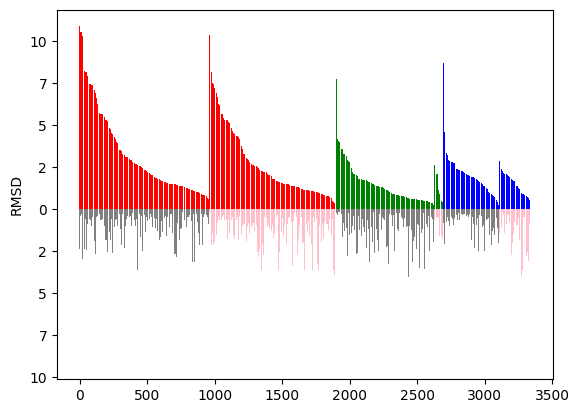

In [12]:
results_combined_sorted = results_combined.sort_values(by=['cdr_tcr', 'chain_type_pmhc','rmsd_tcr'], ascending=False)

data = results_combined_sorted[['rmsd_tcr', 'rmsd_pmhc']].to_numpy()

tcr_colours = results_combined_sorted['cdr_tcr'].apply(int).map(lambda cdr_num: 'blue' if cdr_num == 1 else 'green' if cdr_num == 2 else 'red').to_list()
pmhc_colours = results_combined_sorted['chain_type_pmhc'].map(lambda chain_type: 'grey' if chain_type == 'mhc_chain' else 'pink').to_list()

y1 = data[:, 0]
y2 = -data[:, 1]

x = range(len(y1))



fig, ax = plt.subplots()

ax.bar(x, y1, color = tcr_colours)
ax.bar(x, y2, color = pmhc_colours)


# Use absolute value for y-ticks
ticks =  ax.get_yticks()
ax.set_yticklabels([int(abs(tick)) for tick in ticks])
ax.set_ylabel('RMSD')

print()
# plt.savefig('tcr-pmhc-correlation.svg')

/tmp/ipykernel_2659650/342025215.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(abs(tick)) for tick in ticks])


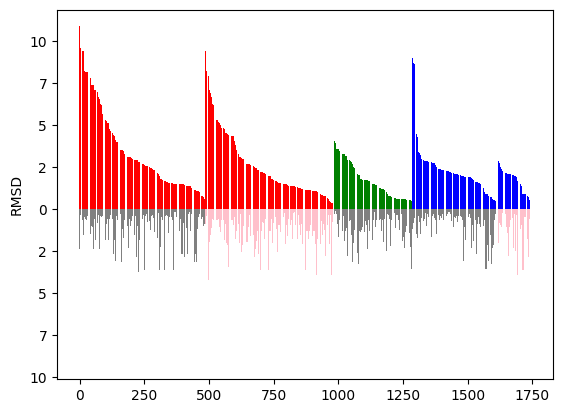

In [13]:
results_combined_sorted = results_combined.sort_values(by=['cdr_tcr', 'chain_type_pmhc','rmsd_tcr'], ascending=False)
results_combined_sorted_alpha = results_combined_sorted.query("chain_type_tcr == 'alpha_chain'")

data = results_combined_sorted_alpha[['rmsd_tcr', 'rmsd_pmhc']].to_numpy()

tcr_colours = results_combined_sorted_alpha['cdr_tcr'].apply(int).map(lambda cdr_num: 'blue' if cdr_num == 1 else 'green' if cdr_num == 2 else 'red').to_list()
pmhc_colours = results_combined_sorted_alpha['chain_type_pmhc'].map(lambda chain_type: 'grey' if chain_type == 'mhc_chain' else 'pink').to_list()

y1 = data[:, 0]
y2 = -data[:, 1]

x = range(len(y1))



fig, ax = plt.subplots()

ax.bar(x, y1, color = tcr_colours)
ax.bar(x, y2, color = pmhc_colours)


# Use absolute value for y-ticks
ticks =  ax.get_yticks()
ax.set_yticklabels([int(abs(tick)) for tick in ticks])
ax.set_ylabel('RMSD')

print()
plt.savefig('tcr-pmhc-correlation_alpha.svg')

/tmp/ipykernel_2659650/3465633642.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(abs(tick)) for tick in ticks])


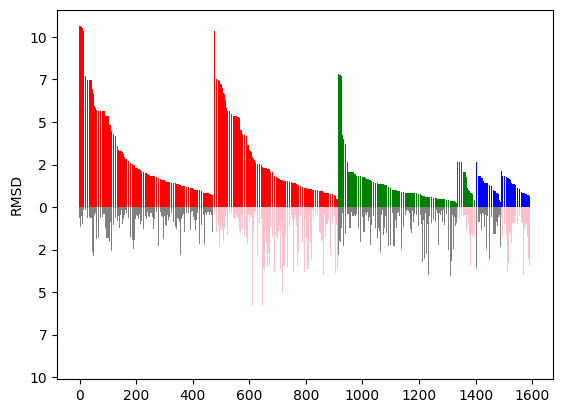

In [14]:
results_combined_sorted_beta = results_combined.query("chain_type_tcr == 'beta_chain'").sort_values(by=['cdr_tcr', 'chain_type_pmhc','rmsd_tcr'], ascending=False)

data = results_combined_sorted_beta[['rmsd_tcr', 'rmsd_pmhc']].to_numpy()

tcr_colours = results_combined_sorted_beta['cdr_tcr'].apply(int).map(lambda cdr_num: 'blue' if cdr_num == 1 else 'green' if cdr_num == 2 else 'red').to_list()
pmhc_colours = results_combined_sorted_beta['chain_type_pmhc'].map(lambda chain_type: 'grey' if chain_type == 'mhc_chain' else 'pink').to_list()

y1 = data[:, 0]
y2 = -data[:, 1]

x = range(len(y1))



fig, ax = plt.subplots()

ax.bar(x, y1, color = tcr_colours)
ax.bar(x, y2, color = pmhc_colours)


# Use absolute value for y-ticks
ticks =  ax.get_yticks()
ax.set_yticklabels([int(abs(tick)) for tick in ticks])
ax.set_ylabel('RMSD')

print()
plt.savefig('tcr-pmhc-correlation_beta.svg')

In [15]:
results_combined_sorted_beta

,name,group_name,chain_id_tcr,residue_seq_id_tcr,residue_insert_code_tcr,residue_name_tcr,cdr_tcr,chain_type_tcr,chain_id_pmhc,residue_seq_id_pmhc,residue_insert_code_pmhc,residue_name_pmhc,distance,rmsd_tcr,chain_type_pmhc,rmsd_pmhc
1290,tcr-pmhc_6eqb_DECA.pdb,hla_a_02_01_aagigiltv_FLGSQS-TYREGD-AVNDGGRLT-...,E,111,None,LEU,3.0,beta_chain,A,1066,None,GLN,4.532884,10.616866,mhc_chain,0.654079
2004,tcr-pmhc_6eqb_DECA.pdb,hla_a_02_01_aagigiltv_FLGSQS-TYREGD-AVNDGGRLT-...,E,111,None,LEU,3.0,beta_chain,A,66,None,LYS,3.839512,10.616866,mhc_chain,0.668413
3181,tcr-pmhc_6eqb_DECA.pdb,hla_a_02_01_aagigiltv_FLGSQS-TYREGD-AVNDGGRLT-...,E,111,None,LEU,3.0,beta_chain,A,69,None,ALA,3.493174,10.616866,mhc_chain,0.477937
3182,tcr-pmhc_6eqb_DECA.pdb,hla_a_02_01_aagigiltv_FLGSQS-TYREGD-AVNDGGRLT-...,E,111,None,LEU,3.0,beta_chain,A,70,None,HIS,3.312408,10.616866,mhc_chain,1.184757
845,tcr-pmhc_4jff_DECA.pdb,hla_a_02_01_elagigiltv_FLGSQS-TYREGD-AVNDGGRLT...,E,111,None,LEU,3.0,beta_chain,A,66,None,LYS,4.049145,10.564187,mhc_chain,0.388569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,tcr-pmhc_3w0w_DECA.pdb,hla_a_24_02_rfpltfgwcf_DRGSQS-IYSNGD-GTYNQGGKL...,E,38,None,TYR,1.0,beta_chain,C,6,None,PHE,3.992571,0.673512,antigen_chain,3.472578
681,tcr-pmhc_3vxu_DECA.pdb,hla_a_24_02_rfpltfgwcf_DRGSQS-IYSNGD-GTYNQGGKL...,E,38,None,TYR,1.0,beta_chain,C,6,None,PHE,3.193049,0.673512,antigen_chain,3.472578
682,tcr-pmhc_3w0w_DECA.pdb,hla_a_24_02_rfpltfgwcf_DRGSQS-IYSNGD-GTYNQGGKL...,E,38,None,TYR,1.0,beta_chain,C,6,None,PHE,3.528373,0.673512,antigen_chain,3.472578
683,tcr-pmhc_3vxu_DECA.pdb,hla_a_24_02_rfpltfgwcf_DRGSQS-IYSNGD-GTYNQGGKL...,E,38,None,TYR,1.0,beta_chain,C,6,None,PHE,3.305507,0.673512,antigen_chain,3.472578


## MHC Contacts Influenced by TCR

In [21]:
results_combined['resi_pmhc'] = results_combined['residue_seq_id_pmhc'].apply(str) + results_combined['residue_insert_code_pmhc'].fillna('')

In [25]:
results_combined

,name,group_name,chain_id_tcr,residue_seq_id_tcr,residue_insert_code_tcr,residue_name_tcr,cdr_tcr,chain_type_tcr,chain_id_pmhc,residue_seq_id_pmhc,residue_insert_code_pmhc,residue_name_pmhc,distance,rmsd_tcr,chain_type_pmhc,rmsd_pmhc,resi_pmhc
0,tcr-pmhc_1ao7_DECA.pdb,hla_a_02_01_llfgypvyv_DRGSQS-IYSNGD-AVTTDSWGKL...,D,27,None,ASP,1.0,alpha_chain,A,58,None,GLU,3.295080,1.837311,mhc_chain,2.293643,58
1,tcr-pmhc_1ao7_DECA.pdb,hla_a_02_01_llfgypvyv_DRGSQS-IYSNGD-AVTTDSWGKL...,D,27,None,ASP,1.0,alpha_chain,A,58,None,GLU,4.252961,1.837311,mhc_chain,2.293643,58
2,tcr-pmhc_1ao7_DECA.pdb,hla_a_02_01_llfgypvyv_DRGSQS-IYSNGD-AVTTDSWGKL...,D,27,None,ASP,1.0,alpha_chain,A,58,None,GLU,4.307117,1.837311,mhc_chain,2.293643,58
3,tcr-pmhc_1ao7_DECA.pdb,hla_a_02_01_llfgypvyv_DRGSQS-IYSNGD-AVTTDSWGKL...,D,28,None,ARG,1.0,alpha_chain,A,58,None,GLU,4.641895,1.988620,mhc_chain,2.293643,58
4,tcr-pmhc_6amu_DECA.pdb,hla_a_02_01_mmwdrglgmm_DRGSQS-IYSNGD-AVNFGGGKL...,D,27,None,ASP,1.0,alpha_chain,A,58,None,GLU,4.251688,4.503006,mhc_chain,1.741666,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,tcr-pmhc_7r80_ABEC.pdb,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,B,108,None,TYR,3.0,beta_chain,C,1062,None,ARG,2.995913,3.300491,mhc_chain,2.519925,1062
3333,tcr-pmhc_7r80_ABEC.pdb,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,B,114,None,TYR,3.0,beta_chain,C,1062,None,ARG,3.191215,2.705542,mhc_chain,2.519925,1062
3334,tcr-pmhc_7r80_ABEC.pdb,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,B,113,None,ASN,3.0,beta_chain,C,1065,None,GLU,3.583144,1.233543,mhc_chain,0.831959,1065
3335,tcr-pmhc_7r80_ABEC.pdb,hla_b_53_01_qasqevknw_DSAIYN-IQSSQRE-AQLNQAGTA...,B,114,None,TYR,3.0,beta_chain,C,1065,None,GLU,2.193649,2.705542,mhc_chain,0.831959,1065


In [32]:
results_combined_mhc = results_combined.query("chain_type_pmhc == 'mhc_chain'")
results_combined_mhc_filtered = results_combined_mhc.groupby('resi_pmhc').filter(lambda group: len(group) >= 10)

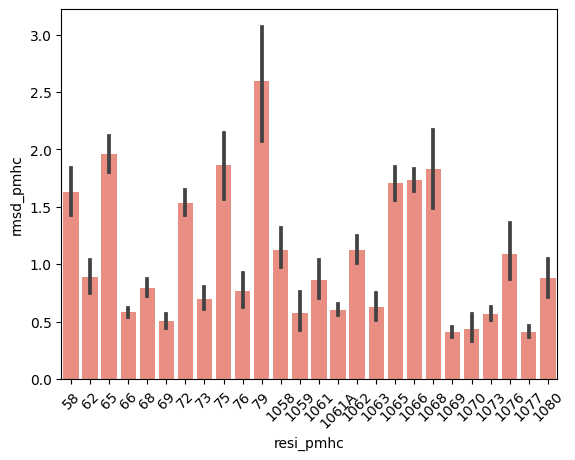

In [33]:
sns.barplot(results_combined_mhc_filtered.sort_values('residue_seq_id_pmhc'),
            x='resi_pmhc',
            y='rmsd_pmhc',
            color='salmon')
plt.xticks(rotation=45)
print()

In [38]:
results_combined_mhc_filtered['cdr_name'] = 'CDR-' \
+ results_combined_mhc_filtered['chain_type_tcr'].map(lambda chain: 'A' if chain == 'alpha_chain' else 'B') \
+ results_combined_mhc_filtered['cdr_tcr'].apply(int).apply(str)

In [76]:
contacting_tcr = (results_combined_mhc_filtered.value_counts(['resi_pmhc', 'cdr_name'])
                                               .reset_index()
                                               .drop_duplicates(['resi_pmhc'])[['resi_pmhc', 'cdr_name']])

contacting_tcr = contacting_tcr.rename(columns={'cdr_name': 'dominant_cdr_contact'})

contacting_tcr

,resi_pmhc,dominant_cdr_contact
0,72,CDR-B2
1,66,CDR-A3
2,65,CDR-A3
3,1061A,CDR-B3
4,1066,CDR-B3
5,62,CDR-A3
6,1065,CDR-A2
7,1069,CDR-A2
8,76,CDR-B2
10,1073,CDR-A1


In [78]:
results_combined_mhc_filtered_annotated_cdr = results_combined_mhc_filtered.merge(contacting_tcr, on='resi_pmhc', how='outer')

In [87]:
colour = contacting_tcr.sort_values('resi_pmhc')['dominant_cdr_contact'].map({
    'CDR-A1': 'blue',
    'CDR-A2': 'orange',
    'CDR-A3': 'green',
    'CDR-B1': 'red',
    'CDR-B2': 'pink',
    'CDR-B3': 'purple',
})
colour

27    purple
42    purple
35    purple
3     purple
12    orange
13    purple
6     orange
4     purple
38    orange
7     orange
18      blue
10      blue
33      blue
20      blue
40      blue
24      blue
5      green
2      green
1      green
22      pink
14      pink
0       pink
17      pink
15      pink
8       pink
32      pink
Name: dominant_cdr_contact, dtype: object

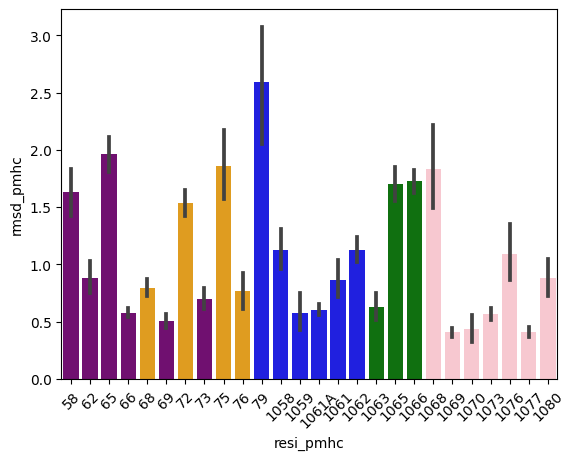

In [89]:
sns.barplot(results_combined_mhc_filtered_annotated_cdr.sort_values('residue_seq_id_pmhc'),
            x='resi_pmhc',
            y='rmsd_pmhc',
            palette=colour)
plt.xticks(rotation=45)
print()
# plt.savefig('figures/mhc-contact-rmsd_with_cdr.svg')